# Activity Coefficient Models

## Overview

The `polykin.thermo.acm` module provides activity coefficient models to estimate the
thermodynamic properties of nonideal liquid multicomponent solutions.

For non-polymer solutions, the NRTL and UNIQUAC models stand out as the most popular,
versatile, and overall best-performing alternatives. These models excel in handling strongly
nonideal mixtures and are applicable to both vapor-liquid (VLE) and liquid-liquid equilibria
(LLE).

In polymer solutions, the Flory-Huggins model remains an indispensable classic, albeit with
somewhat limited performance. For complex solutions, the PolyNRTL model is a far superior
choice, extending the capabilities of the NRTL model to encompass mixtures with polymer
components. 

| Model           | VLE | LLE | Polymer solutions |
|-----------------|:---:|:---:|:-----------------:|
| `NRTL`          |  ✓  |  ✓  |         —         |
| `UNIQUAC`       |  ✓  |  ✓  |         —         |
| `FloryHuggings` |  ✓  |  ✓  |         ✓         |
| `PolyNRTL`      |  ✓  |  ✓  |         ✓         |

## Non-polymer solutions

The `NRTL` and `UNIQUAC` classes are used in the same way and have the same built-in methods.
We provide an example of VLE calculations with UNIQUAC and an example of LLE calculations with
NRTL.

### VLE

For this demonstration, let us consider the binary system water / ethylene glycol (EG) with
the UNIQUAC parameters reported by [Lancia et al. (1996)](https://doi.org/10.1252/jcej.29.449).

| Binary parameter |      Value      |
|------------------|:---------------:|
| Component $i$    |      Water      |
| Component $j$    | Ethylene glycol |
| $a_{ij}$         |       3.97      |
| $a_{ji}$         |      -10.3      |
| $b_{ij}$ [K]     |      -1194      |
| $b_{ji}$ [K]     |       3359      |

&nbsp;

| Component       |  $r$ | $q$  |
|-----------------|:----:|------|
| Water           | 0.92 | 1.4  |
| Ethylene glycol | 2.41 | 2.25 |

First, we create arrays to store the unary and binary interaction parameters, and then we
construct the activity coefficient model object.

In [1]:
# %pip install polykin
from polykin.thermo.acm import UNIQUAC
import numpy as np

# pure-component parameters
r = np.array([0.92, 2.41])
q = np.array([1.4, 2.25])

# binary interaction parameters
N = 2
a = np.zeros((N, N))
b = np.zeros((N, N))
a[0, 1] = 3.974
a[1, 0] = -10.33
b[0, 1] = -1194
b[1, 0] = 3359

thermo = UNIQUAC(N, q, r, a=a, b=b) 

We can now evaluate mixing properties, excess properties, activity coefficients, activities,
etc. Let's compute and plot the Gibbs energy of mixing, the excess enthalpy, and the activity
coefficients as a function of composition at 373 K.

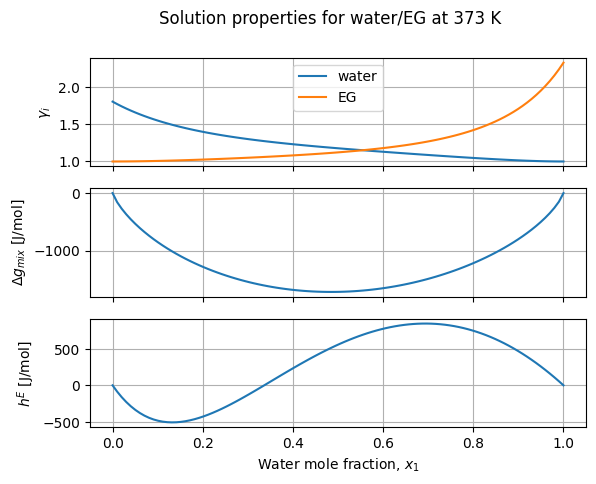

In [2]:
import matplotlib.pyplot as plt

# Generate molar fraction mesh and evaluate properties
x1 = np.linspace(0, 1, 100)
T = 373 # K
gamma = []
Dgmix = []
hE = []
for x1val in x1:
    args = (T, np.array([x1val, 1 - x1val]))
    gamma.append(thermo.gamma(*args))
    Dgmix.append(thermo.Dgmix(*args))
    hE.append(thermo.hE(*args))

fig, ax = plt.subplots(3, sharex=True)
fig.suptitle(f"Solution properties for water/EG at {T} K")
ax[-1].set_xlabel(r"Water mole fraction, $x_{1}$")
_ = [axis.grid(True) for axis in ax]

ax[0].set_ylabel(r"$\gamma_{i}$")
gamma = np.asarray(gamma)
ax[0].plot(x1, gamma[:, 0], label="water")
ax[0].plot(x1, gamma[:, 1], label="EG")
ax[0].legend(loc="upper center")

ax[1].set_ylabel(r"$\Delta g_{mix}$ [J/mol]")
ax[1].plot(x1, Dgmix)

ax[2].set_ylabel(r"$h^{E}$ [J/mol]")
ax[2].plot(x1, hE)

The convexity of the $\Delta g_{mix}$ plot indicates that the solution is homogeneous. The activity coefficient plot shows the solution exhibits moderate deviations from Raoult's law, with infinite dilution activity coefficients of about 2.

Let us further compute and plot the Pxy diagram for the same conditions. For that, we need the vapor pressures of water and EG, which are also provided in the abovementioned reference.

In [3]:
from polykin.properties.equations import Antoine

In [4]:
unit_conv = np.log10(1.01325/760)
Psat_water = Antoine(A=(8.07131 + unit_conv),
                     B=1730.63,
                     C=(233.426 - 273.15),
                     unit="bar",
                     name="water")
Psat_EG = Antoine(A=(8.09083 + unit_conv),
                     B=2088.936,
                     C=(203.454 - 273.15),
                     unit="bar",
                     name="EG")
Psat = [Psat_water, Psat_EG]

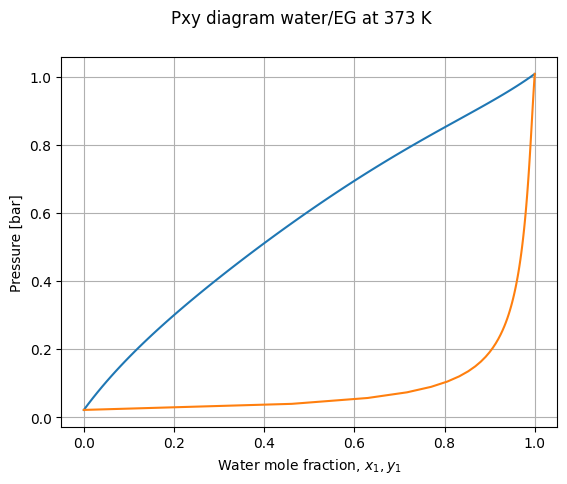

In [5]:
# Bubble pressure
Pbubble = x1*gamma[:, 0]*Psat[0](T) + (1 - x1)*gamma[:, 1]*Psat[1](T)

# Vapor composition
y1 = x1*gamma[:, 0]*Psat_water(T)/Pbubble

fig, ax = plt.subplots()
fig.suptitle(f"Pxy diagram water/EG at {T} K")
ax.set_xlabel(r"Water mole fraction, $x_{1}, y_{1}$")
ax.set_ylabel("Pressure [bar]")
ax.grid(True)

ax.plot(x1, Pbubble)
ax.plot(y1, Pbubble)